## Discovering TCGs and Changepoints from Time Series (Chapter 5)

SpaceTime discovers graphical models (window causal graphs) from non-stationary time series datasets with regime changes.


In [4]:

%load_ext autoreload
%autoreload 2

import os, sys
import logging
import warnings

import numpy as np
from matplotlib import pyplot as plt

from src.exp.exp_stime.utils.gen_timeseries import gen_timeseries
from src.stime import SpaceTime

import src.exp.exp_stime.utils.plot_timeseries as stp
from tigramite.toymodels import structural_causal_processes as toys
import tigramite.plotting as tp

sys.path.insert(0, os.path.abspath(".."))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Generating Synthetic Data



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


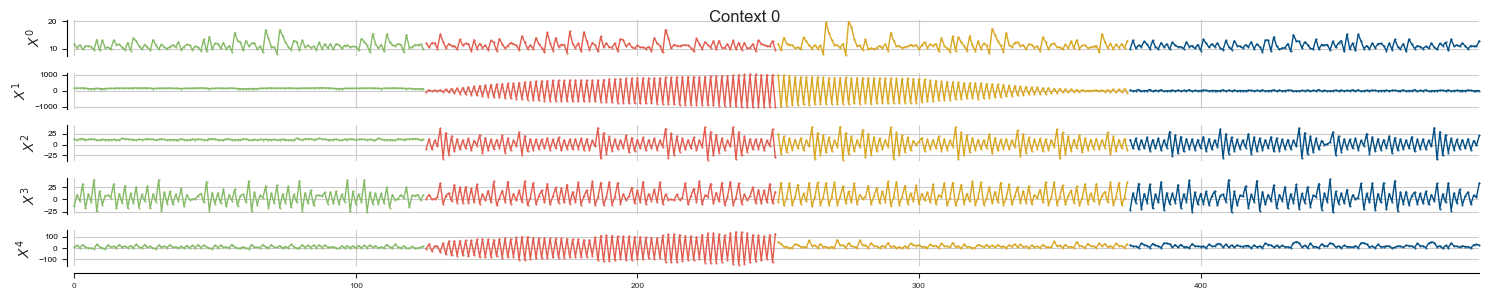

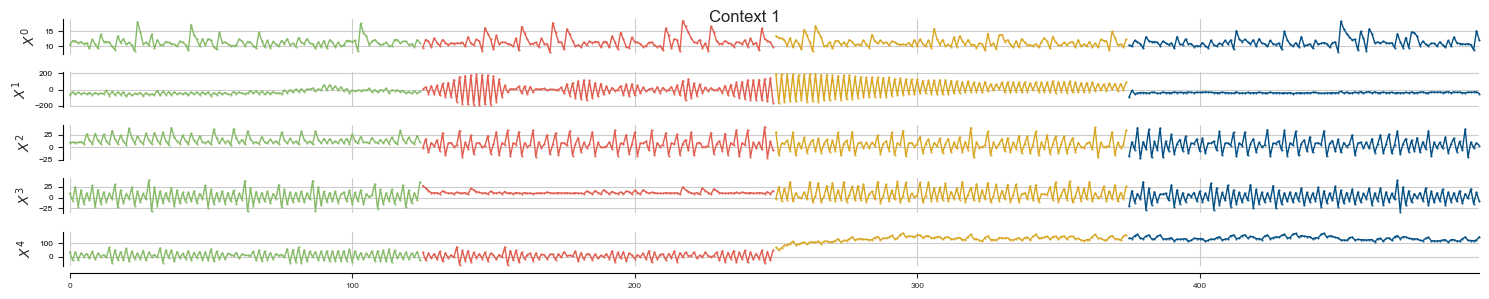

In [5]:
logging.basicConfig()
lg = logging.getLogger("EXAMPLE")
lg.setLevel("INFO")

# DATA  
true_tau_max = 1
true_min_dur = 30
hat_tau_max = 1
hat_min_dur = 20
seed = 1
np.random.seed(seed)

params = {'C': 2, 'R': 4, 'CPS': 3, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition)

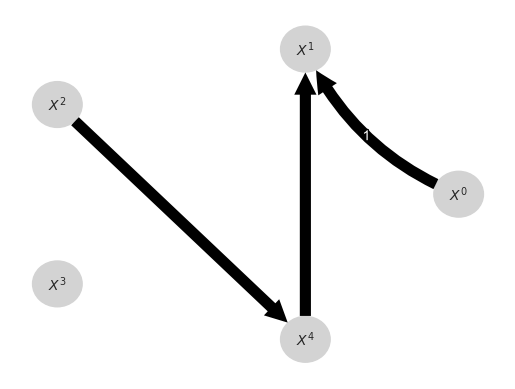

In [6]:
gt_graph = toys.links_to_graph(truths.true_links, tau_max=true_tau_max+1)
var_names = [rf'$X^{i}$' for i in range(params['N'])]
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

### 2. SPACETIME: Causal Discovery, Changepoint Detection, and partitioning

#### 2.1. Causal Discovery

In [7]:
from src.stime import MethodType
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_REGIMES
    st_known_cps = SpaceTime(hat_tau_max, hat_min_dur, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_cps.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st_oracle_regimes)***
INFO:EXAMPLE:Interleaving Iteration 1/max. 1*
INFO:EXAMPLE:	Initialise DAG search:  use true regimes [(1, 125), (126, 250), (251, 375), (376, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 0) -> 1: s=188.17	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2EDDEA680>
INFO:EXAMPLE:Forward: 16.41s 
INFO:EXAMPLE:Phase 2: Backward
INFO:EXAMPLE:Backward: 1.91s 
INFO:EXAMPLE:DAG search result:4->1
INFO:EXAMPLE:	> DAG Result (hybrid: False, R*: True):
INFO:EXAMPLE:		st_oracle_regimes:		(f1=0.5	(shd=2.0, sid=-1)	(tp=1, tn=22, fp=0, fn=2)
INFO:EXAMPLE:		st_oracle_regimes-timed:		(f1=0.22	(shd=7.0, sid=-1)	(tp=1, tn=42, fp=0, fn=7)
INFO:EXAMPLE:Completed run in 1 iterations. 


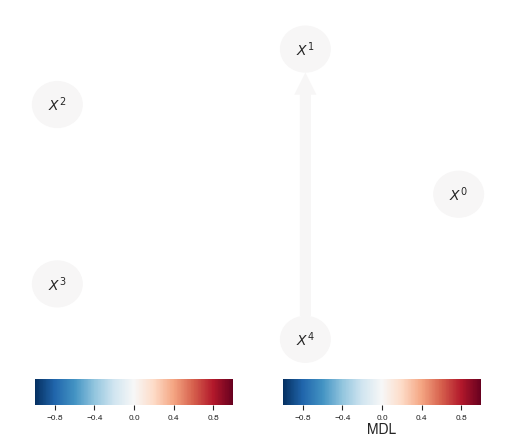

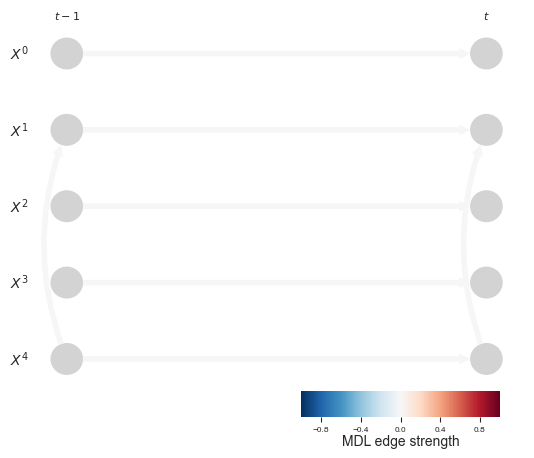

In [10]:
dag_model = st_known_cps.result.cur_dag_model
adj = dag_model.get_timed_adj()
t_adj = dag_model.get_timed_adj()
strength_mat = np.zeros((dag_model.n_n, dag_model.n_n, dag_model.max_lag+1))

for i in dag_model.nodes:
    for j in dag_model.nodes:
        for lag in range(dag_model.max_lag):
            if dag_model.is_edge((i, lag), j):
                index = dag_model.n_n * lag + i
                assert t_adj[index][j] != 0
                strength_mat[i][j][lag + 1] = dag_model.eval_edge(j, [(i, lag)])
    strength_mat[i][i][0] = dag_model.eval_edge(i, [(i, -1)])
    # convention: self-strengths at 0

xmin, xmax = np.min(np.min(np.min(strength_mat, axis=0), axis=0)), np.max(np.max(np.max(strength_mat, axis=0), axis=0))
strength_mat = (strength_mat - xmin)/(xmax - xmin) # scale between zero and one
rmin = 0 #-1
strength_mat = strength_mat * (1 - rmin) + rmin #scale to a different range.     
#strength_mat /= np.max(np.max(np.max(strength_mat, axis=0), axis=0)) 
found_links = st_known_cps.result.cur_links[0]
gt_graph = toys.links_to_graph(found_links, tau_max=st_known_cps.max_lag)
var_names = [rf'$X^{i}$' for i in range(len(found_links))] 
tp.plot_graph(
    val_matrix=strength_mat,
    graph=gt_graph,
    link_colorbar_label="MDL",
    node_colorbar_label="",
    var_names=var_names,
);
plt.show()
tp.plot_time_series_graph(
    val_matrix=strength_mat,
    graph=gt_graph,
    var_names=var_names,
    link_colorbar_label='MDL edge strength',
 ); 
plt.show() 

#### 2.2. CPS Detection 

In [11]:
from src.stime import MethodType
from src.stime import  DiscrepancyTestType

with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    method = MethodType.ST_GP_DAG
    st_known_dag = SpaceTime(hat_tau_max, hat_min_dur, discrepancy_test = DiscrepancyTestType.KCI, method_type=method, truths=truths, logger=lg, verbosity=2)
    st_known_dag.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st_oracle_dag)***
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:	> CPS Result (G*: given, initialization: bins): [(0, 143, np.float64(0.0)), (143, 112, np.float64(1.0)), (255, 88, np.float64(2.0)), (343, 157, np.float64(3.0))]
INFO:EXAMPLE:	> CPS True: [(0, 125, 2), (125, 125, 3), (250, 125, 1), (375, 125, 0)]
INFO:EXAMPLE:	> CPS F1: 0.0 prec: 0.0, recall: 0.0, ari: 0.744, nmi: 0.783 (max. tol. 3)
INFO:EXAMPLE:Interleaving Iteration 2/max. 10*
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:CPS search converged!
INFO:EXAMPLE:	> CPS Result (G*: given): [(0, 143, np.float64(0.0)), (143, 112, np.float64(1.0)), (255, 88, np.float64(2.0)), (343, 157, np.float64(3.0))]
INFO:EXAMPLE:	> CPS True: [(0, 125, 2), (125, 125, 3), (250, 125, 1), (375, 125, 0)]
INFO:EXAMPLE:	> CPS F1: 0.0 prec: 0.0, recall: 0.0, ari: 0.744, nmi: 0.783 (max. tol. 3)
INFO:EXAMPLE:Completed run in 2 iterations. 


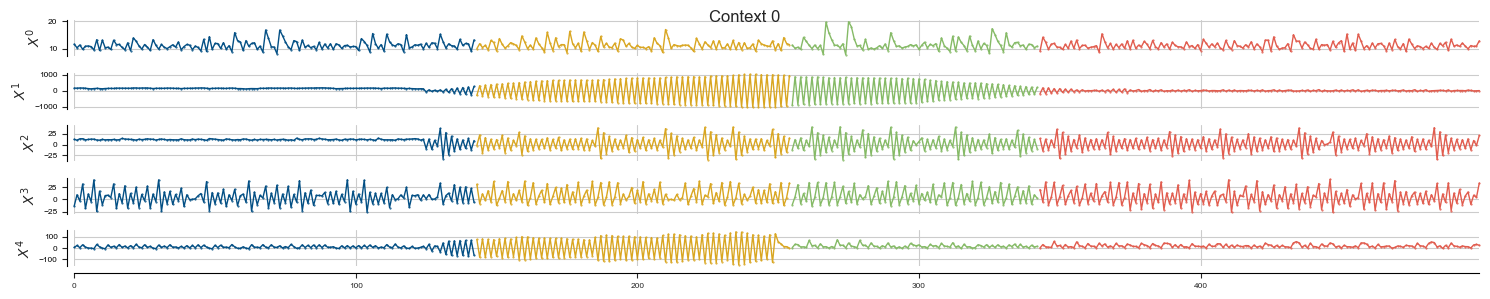

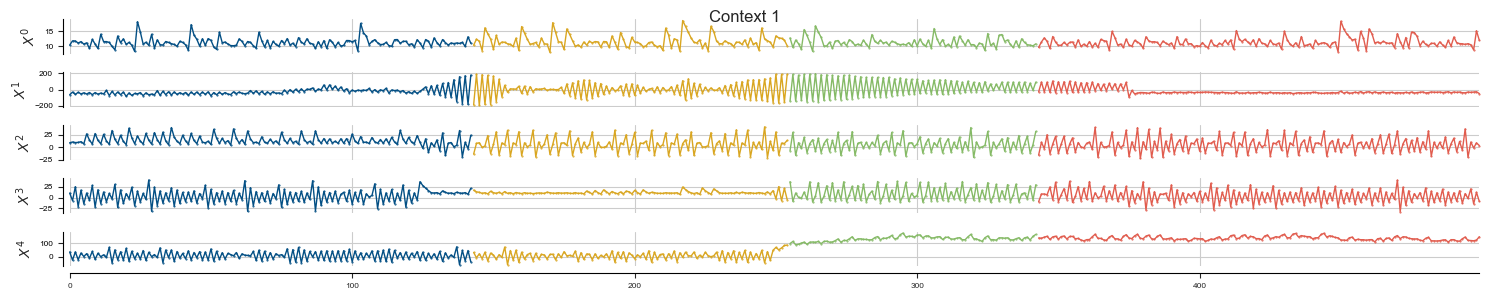

In [12]:
found_regimes = st_known_dag.result.cur_regimes

stp.plot_timeseries_regimes_contexts(data, found_regimes)

#### 2.3. Interleaving C.D. and CPS Discovery

In [17]:
#### 2.3. Full method
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optargs = { }
    st = SpaceTime(hat_tau_max, hat_min_dur, discrepancy_test = DiscrepancyTestType.MDL, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st)***
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:	Initialise DAG search:  use current regimes [(1, 143), (144, 343), (344, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (4, 1) -> 1: s=75.26	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F203C4C0>
INFO:EXAMPLE:	Adding edge (2, 1) -> 4: s=28.13	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F1FF8AF0>
INFO:EXAMPLE:	Adding edge (4, 1) -> 4: s=7.45	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F1FF8A60>
INFO:EXAMPLE:	Adding edge (1, 1) -> 1: s=9.42	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F1FFB880>
INFO:EXAMPLE:Forward: 83.16s 
INFO:EXAMPLE:Phase 2: Backward
INFO:EXAMPLE:Backward: 14.84s 
INFO:EXAMPLE:DAG search result:2->4, 4->1
INFO:EXAMPLE:*** CPS Search ***
INFO:E

INFO:EXAMPLE:	> DAG Result (hybrid: False, R*: False):
INFO:EXAMPLE:		st:		(f1=0.8	(shd=1.0, sid=-1)	(tp=2, tn=22, fp=0, fn=1)
INFO:EXAMPLE:		st-timed:		(f1=0.33	(shd=8.0, sid=-1)	(tp=2, tn=40, fp=2, fn=6)
INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 143, np.float64(0.0)), (143, 200, np.float64(1.0)), (343, 157, np.float64(0.0))]
INFO:EXAMPLE:	> CPS True: [(0, 125, 2), (125, 125, 3), (250, 125, 1), (375, 125, 0)]
INFO:EXAMPLE:	> CPS F1: 0.0 prec: 0.0, recall: 0.0, ari: 0.315, nmi: 0.414 (max. tol. 3)


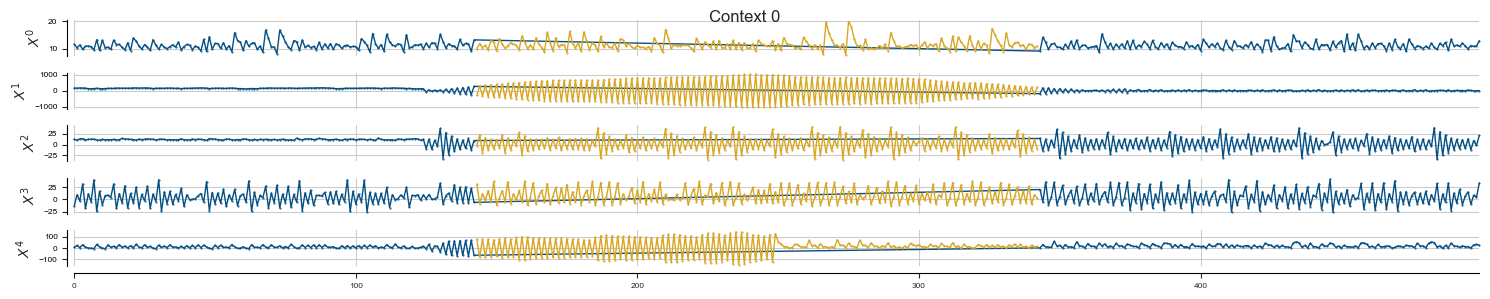

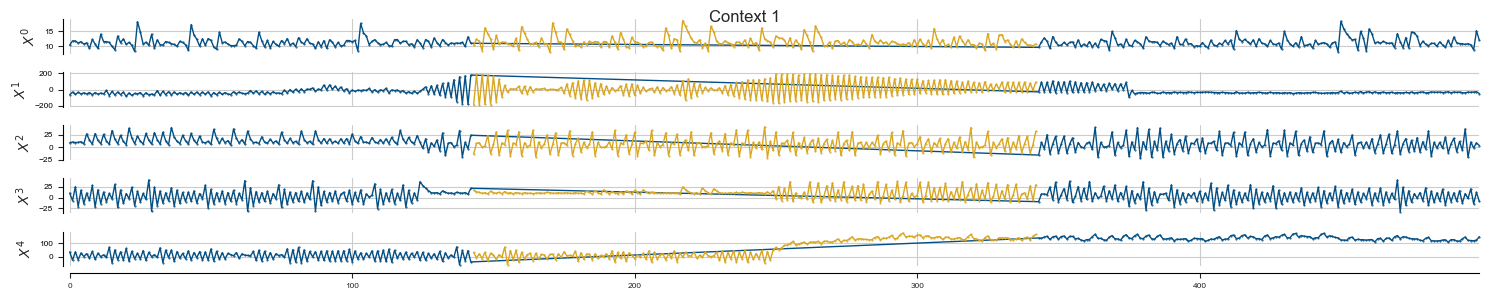

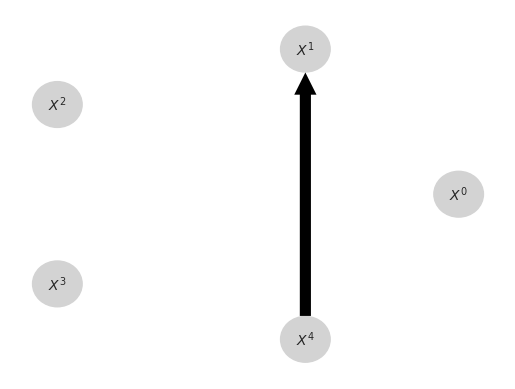

In [18]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()

#### 2.4. Partitioning


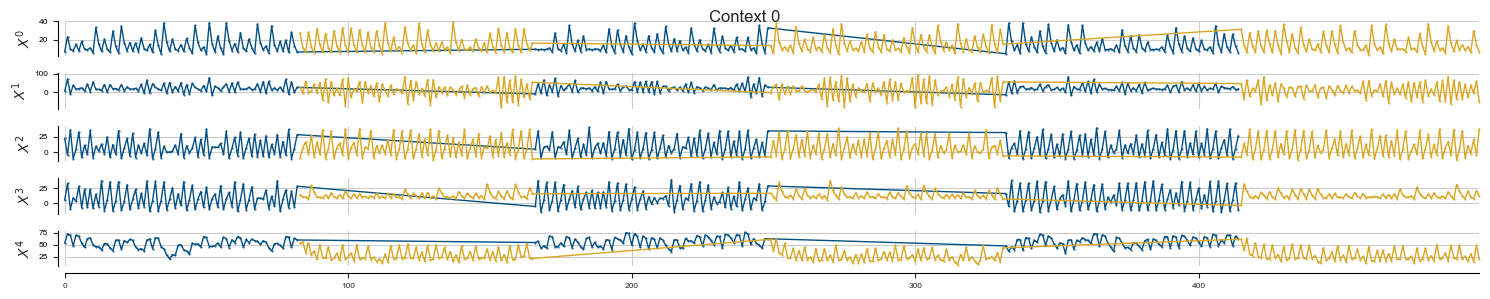

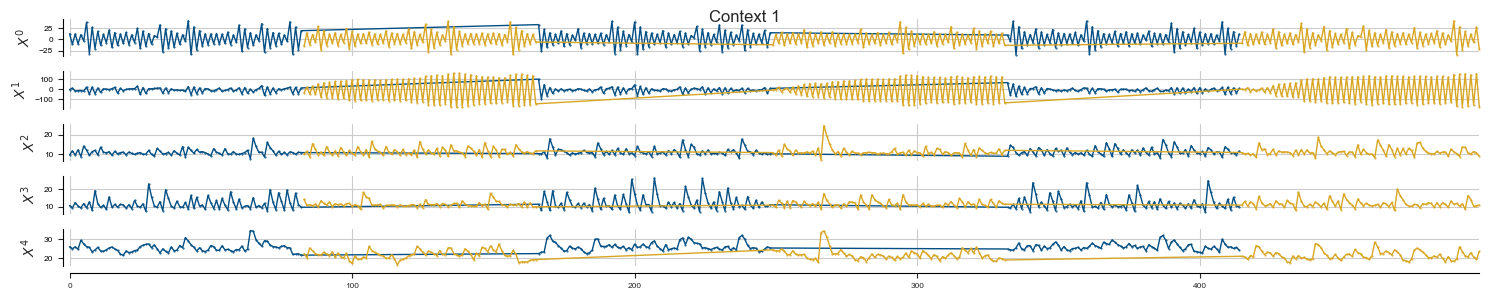

In [19]:
#### 2.4. Partitioning

# Generate a dataset with repeating regimes - 2 regimes at 5 changepoints
params = {'C': 2, 'R': 2, 'CPS': 5, 'T': 500, 'D': 1, 'N': 5, 'I': 0.5}
data, truths = gen_timeseries(true_tau_max, true_min_dur, lg=lg, seed=seed, **params)
 
stp.plot_timeseries_regimes_contexts(data, truths.regimes_partition) 

In [ ]:
# run spacetime
with warnings.catch_warnings():
    warnings.simplefilter("ignore") 
    optargs = {
    'hybrid_cps_dag_discovery': False    
}
    st = SpaceTime(hat_tau_max, hat_min_dur, truths=truths, logger=lg, verbosity=1, **optargs)
    st.run(data.datasets)

INFO:EXAMPLE:*** SpaceTime (st)***
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:Interleaving Iteration 1/max. 10*
INFO:EXAMPLE:	Initialise DAG search:  use current regimes [(1, 89), (90, 168), (169, 267), (268, 332), (333, 436), (437, 500)], taumax 1, hybrid False
INFO:EXAMPLE:*** DAG Search ***
INFO:EXAMPLE:Phase 0: Scoring Edge Pairs
INFO:EXAMPLE:Phase 1: Forward
INFO:EXAMPLE:	Adding edge (2, 0) -> 4: s=285.37	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F3176050>
INFO:EXAMPLE:	Adding edge (0, 0) -> 1: s=37.03	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F31763B0>
INFO:EXAMPLE:	Adding edge (1, 1) -> 1: s=8.01	<function links_to_is_true_edge.<locals>.is_true_edge at 0x000002A2F3176170>
INFO:EXAMPLE:Forward: 43.94s 
INFO:EXAMPLE:Phase 2: Backward
INFO:EXAMPLE:Backward: 10.37s 
INFO:EXAMPLE:DAG search result:0->1, 2->4
INFO:EXAMPLE:*** CPS Search ***
INFO:EXAMPLE:	> DAG Result (hybrid: False, R*: False):
INFO:EXAMPLE:		st:		(f1=0.8	(shd=1.0, s

INFO:EXAMPLE:	> CPS Result (G*: unknown, initialization: noparents): [(0, 79, 0.0), (79, 88, 1.0), (167, 82, 0.0), (249, 85, 1.0), (334, 82, 0.0), (416, 84, 1.0)]
INFO:EXAMPLE:	> CPS True: [(0, 83, 0), (83, 83, 1), (166, 83, 0), (249, 83, 1), (332, 83, 0), (415, 85, 1)]
INFO:EXAMPLE:	> CPS F1: 0.8 prec: 0.8, recall: 0.8, ari: 0.937, nmi: 0.889 (max. tol. 3)


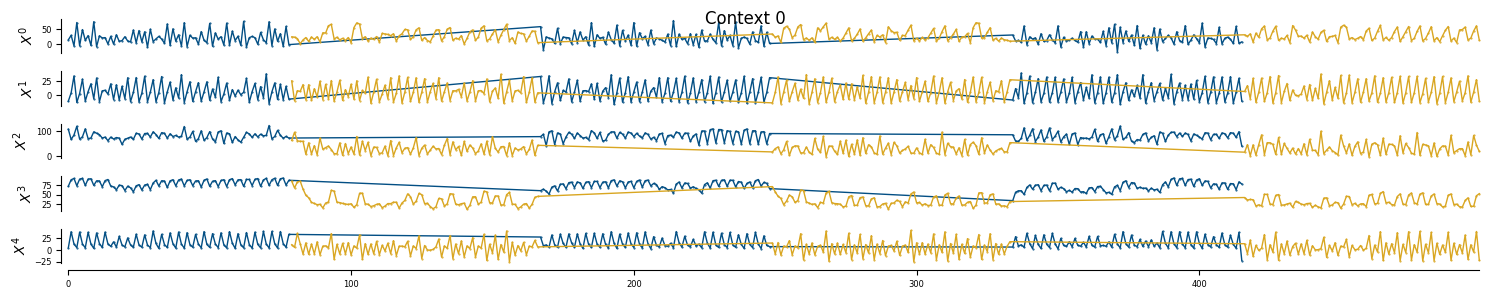

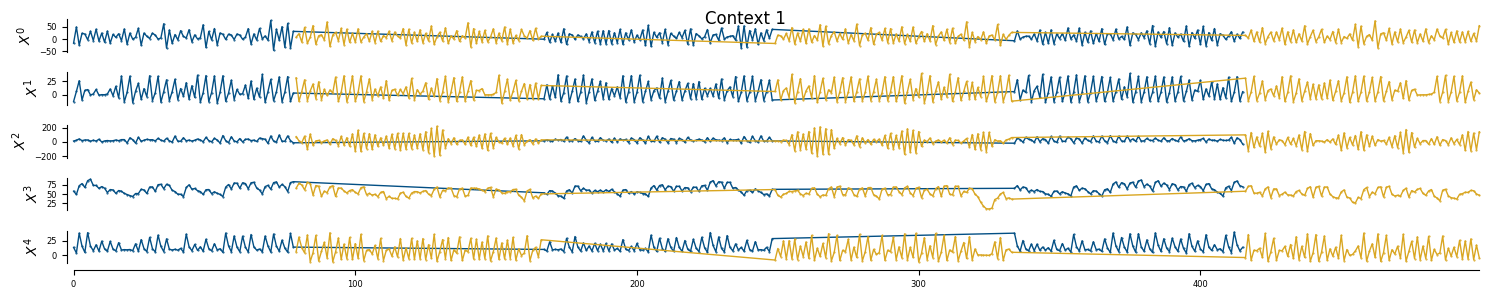

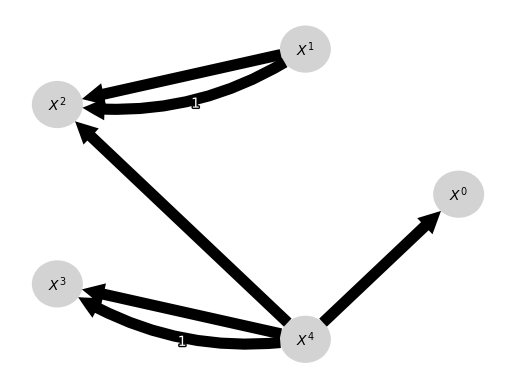

In [37]:
st.get_metrics()
stp.plot_timeseries_regimes_contexts(data, st.result.cur_regimes)
found_links = st_known_cps.result.cur_links[0] 
gt_graph = toys.links_to_graph(found_links, tau_max=true_tau_max+1)
tp.plot_graph( 
    graph=gt_graph,
    var_names=var_names, 
    ); plt.show()